In [1]:
# %%writefile random_forest_model.py
import numpy as np
import pandas as pd
from pymongo import MongoClient
import pprint
import string
import re
import datetime
import copy

from my_tools import get_bill_data

import statsmodels.api as sm
import scipy.stats as scs
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB#, ComplementNB unreleased as of 12/14

import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
data = get_bill_data()

------------------
------------------
Data includes bills, joints resolutions, and laws with text from the 110th Congress (2007) to present
Make changes in my_tools.get_bill_data to modify the data set.
------------------


In [49]:
data = data[data['num_of_amendments'].notna()]

In [51]:
data.labels.value_counts()

0    43578
1     1335
Name: labels, dtype: int64

In [24]:
i_range = []
i_equal = []
i_below = []
i_above = []

for i in range(1, 101):
    df = data[data['num_of_amendments'] == i]
    dfb = data[data['num_of_amendments'] < i]
    dfa = data[data['num_of_amendments'] > i]
    if len(df.labels.value_counts()) == 2:
    #     print(df.labels.value_counts())
        at_value = 100 * df.labels.value_counts()[1] / len(data)
        below_value = 100 * dfb.labels.value_counts()[1] / len(data)
        above_value = 100 * dfa.labels.value_counts()[1] / len(data)
        
        i_range.append(i)
        i_equal.append(at_value)
        i_below.append(below_value)
        i_above.append(above_value)
        

In [25]:
print(len(i_range), len(i_equal), len(i_below), len(i_above))

26 26 26 26


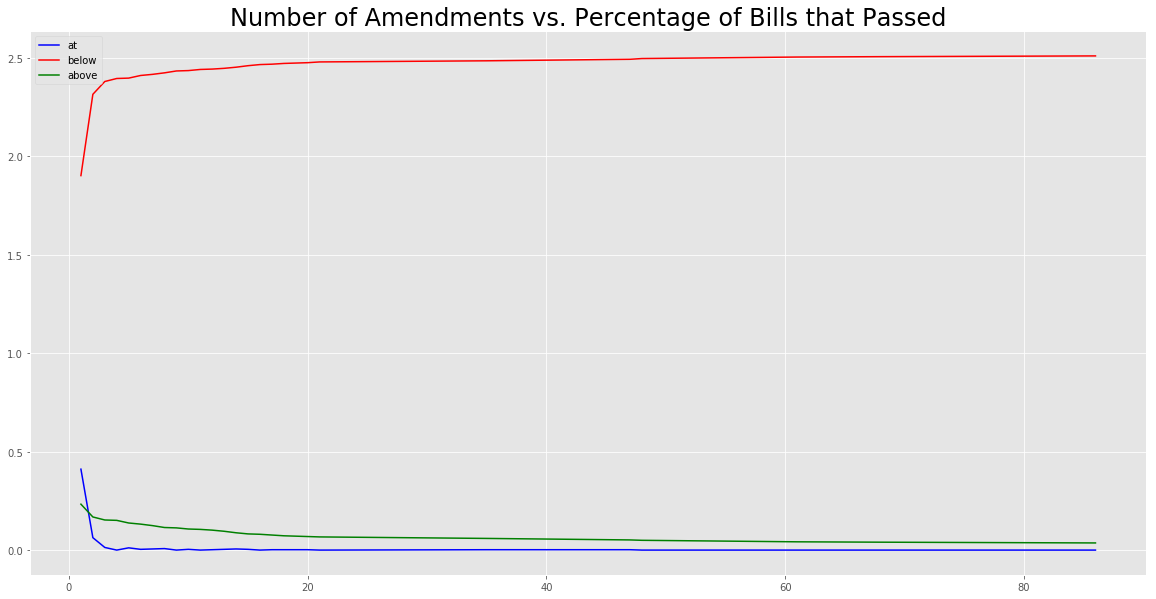

In [36]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
ax.set_title('Number of Amendments vs. Percentage of Bills that Passed', fontdict={'fontsize': 24})
plt.plot(i_range, i_equal, '-b', label='at')
plt.plot(i_range, i_below, '-r', label='below')
plt.plot(i_range, i_above,'-g', label='above')

# ax.hist(data['intro_date'], bins = 500, alpha = .3, color = 'r')
# ax.hist(passed_df['intro_date'], bins = 1000, color = 'g')
# ax.set_xlim(0, 20)
ax.legend()
plt.show()

In [97]:
# First iteration of Random Forest showed that congress_id 115th is a top feature when measured using 
# average Gini importance. Of course it is... nothing was labeled with 0 since every bill that hasn't
# become law is still 'in progress'. The predictions that users will be looking for will always be from the 
# most recent Congress. Therefore, remove congress_id...

# Second iteration removes num_of_cosponsors and bill_char_counts...
data_features = data.loc[:, [
#                             'sponsor',
                            'num_of_cosponsors', 
                            'sponsor_party', 
#                             'sponsor_state', 
                            'num_of_amendments',
                            'bill_char_counts', 
#                             'char_count_bucket',
                            'intro_month', 
                            'session', 
                            'labels'
                            ]]

In [98]:
# get dummies for intro_month, sponsor_party, sponsor_state, session
data_dumm = pd.get_dummies(data_features, columns = [
                                            'intro_month',
#                                             'sponsor',
                                            'sponsor_party', 
#                                             'sponsor_state', 
                                            'session', 
#                                             'char_count_bucket'
                                            ], 
                           drop_first=True)

In [99]:
y = data_dumm.pop('labels').values.astype(int)

recall_scores = []

i = 0
while i < 20:
    X_train, X_test, y_train, y_test = train_test_split(data_dumm, y, 
                                                    stratify = y)
    
    rf = RandomForestClassifier(max_features = 'auto', n_jobs = -1)
    rf.fit(X_train, y_train)

    rf_y_pred = rf.predict(X_test)
    recall_scores.append(recall_score(y_test, rf_y_pred))
    
    i+=1
    

print('Mean recall score after {} iterations: {}'.format(i, np.mean(recall_scores)))

Mean recall score after 20 iterations: 0.18098802395209584


In [55]:
def plot_it(x, y_list, name, labels):
    x = x
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot(111)
    ax.set_title(name, fontdict = {'fontsize': 20})
    for y in y_list:
        plt.plot(x, y)
    plt.legend(labels)

    plt.show

In [80]:
# # Iterate through several n_estimators to find best 
# n_list = range(600, 640, 2)
# r_list = []

# print('----------------')
# print('Iterating through several n_estimators for a Random Forest model...')

# for n in n_list:
#     print('--> n = {}'.format(n))
#     rf = RandomForestClassifier(n_estimators=n, 
#                                 max_features = 'auto', 
#                                 random_state = 123, 
#                                 n_jobs = -1)
#     rf.fit(X_train, y_train)
    
#     rf_y_pred = rf.predict(X_test)
#     r_list.append(recall_score(y_test, rf_y_pred))


In [ ]:
# show graph of scores vs. number of max_features 
x = np.arange(600, 640, 2)
plot_list = [r_list]
graph_name = 'Random Forest n_estimators vs. Recall Score'
labels = ['recall score']

plot_it(x, plot_list, graph_name, labels)

In [ ]:
np.argmax(r_list)

In [ ]:
# random forest classifier
rf = RandomForestClassifier(n_estimators=610, 
                            max_features = 'auto', 
                            random_state = 123, 
                            n_jobs = -1)
rf.fit(X_train, y_train)

In [ ]:
rf_y_pred = rf.predict(X_test)

print('----------------------')
print('----------------------')
print('Random Forest Classification')
print('----------------------')
print('Accuracy score:  {:.2f}'.format(accuracy_score(y_test, rf_y_pred)))
print('Precision score: {:.2f}'.format(precision_score(y_test, rf_y_pred)))
print('Recall score:    {:.2f}'.format(recall_score(y_test, rf_y_pred)))


Text(0.5,0,'Average contribution to information gain')

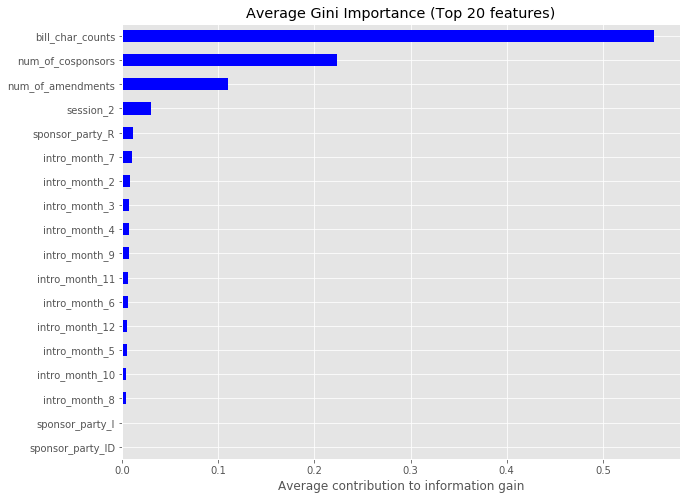

In [100]:
# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=X_train.columns)
feat_scores = feat_scores.sort_values()[::-1][:20][::-1]
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance (Top 20 features)')
ax.set_xlabel('Average contribution to information gain')